In [1]:
import subprocess
import shlex
import re

import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")
TIMING_PATTERN = re.compile(r"\((\d+(?:\.\d+)?)s\)\.")

In [4]:
def test_exponential_inter_event_timing(
    mode, delta_t=1.0, lamda=0.5, seeds=[42], limit=10000000000,
):
    factor = np.sqrt(10 ** abs(np.log10(lamda * delta_t)))
    
    scaled_limit = int(limit / factor)
    
    timings = []
    
    for seed in seeds:
        output = subprocess.run(shlex.split(
            f"cargo run --release --quiet -- --delta-t {delta_t} --seed {seed} " +
            f"--lambda {lamda} --limit {scaled_limit} {CC_PATTERN.sub('-', mode).lower()}"
        ), check=True, capture_output=True, text=True).stdout
        
        timings.append(float(TIMING_PATTERN.search(output).group(1)) * limit / scaled_limit)
    
    return timings

In [5]:
lambdas = [
    0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18,
    0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0,
    180.0, 320.0, 560.0, 1000.0, 1800, 3200, 5600, 10000,
]

seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)

exp_times = [
    test_exponential_inter_event_timing("Exponential", lamda=lamda, seeds=seeds, limit=1000000)
    for lamda in lambdas
]
poi_times = [
    test_exponential_inter_event_timing("Poisson", lamda=lamda, seeds=seeds, limit=1000000)
    for lamda in lambdas
]

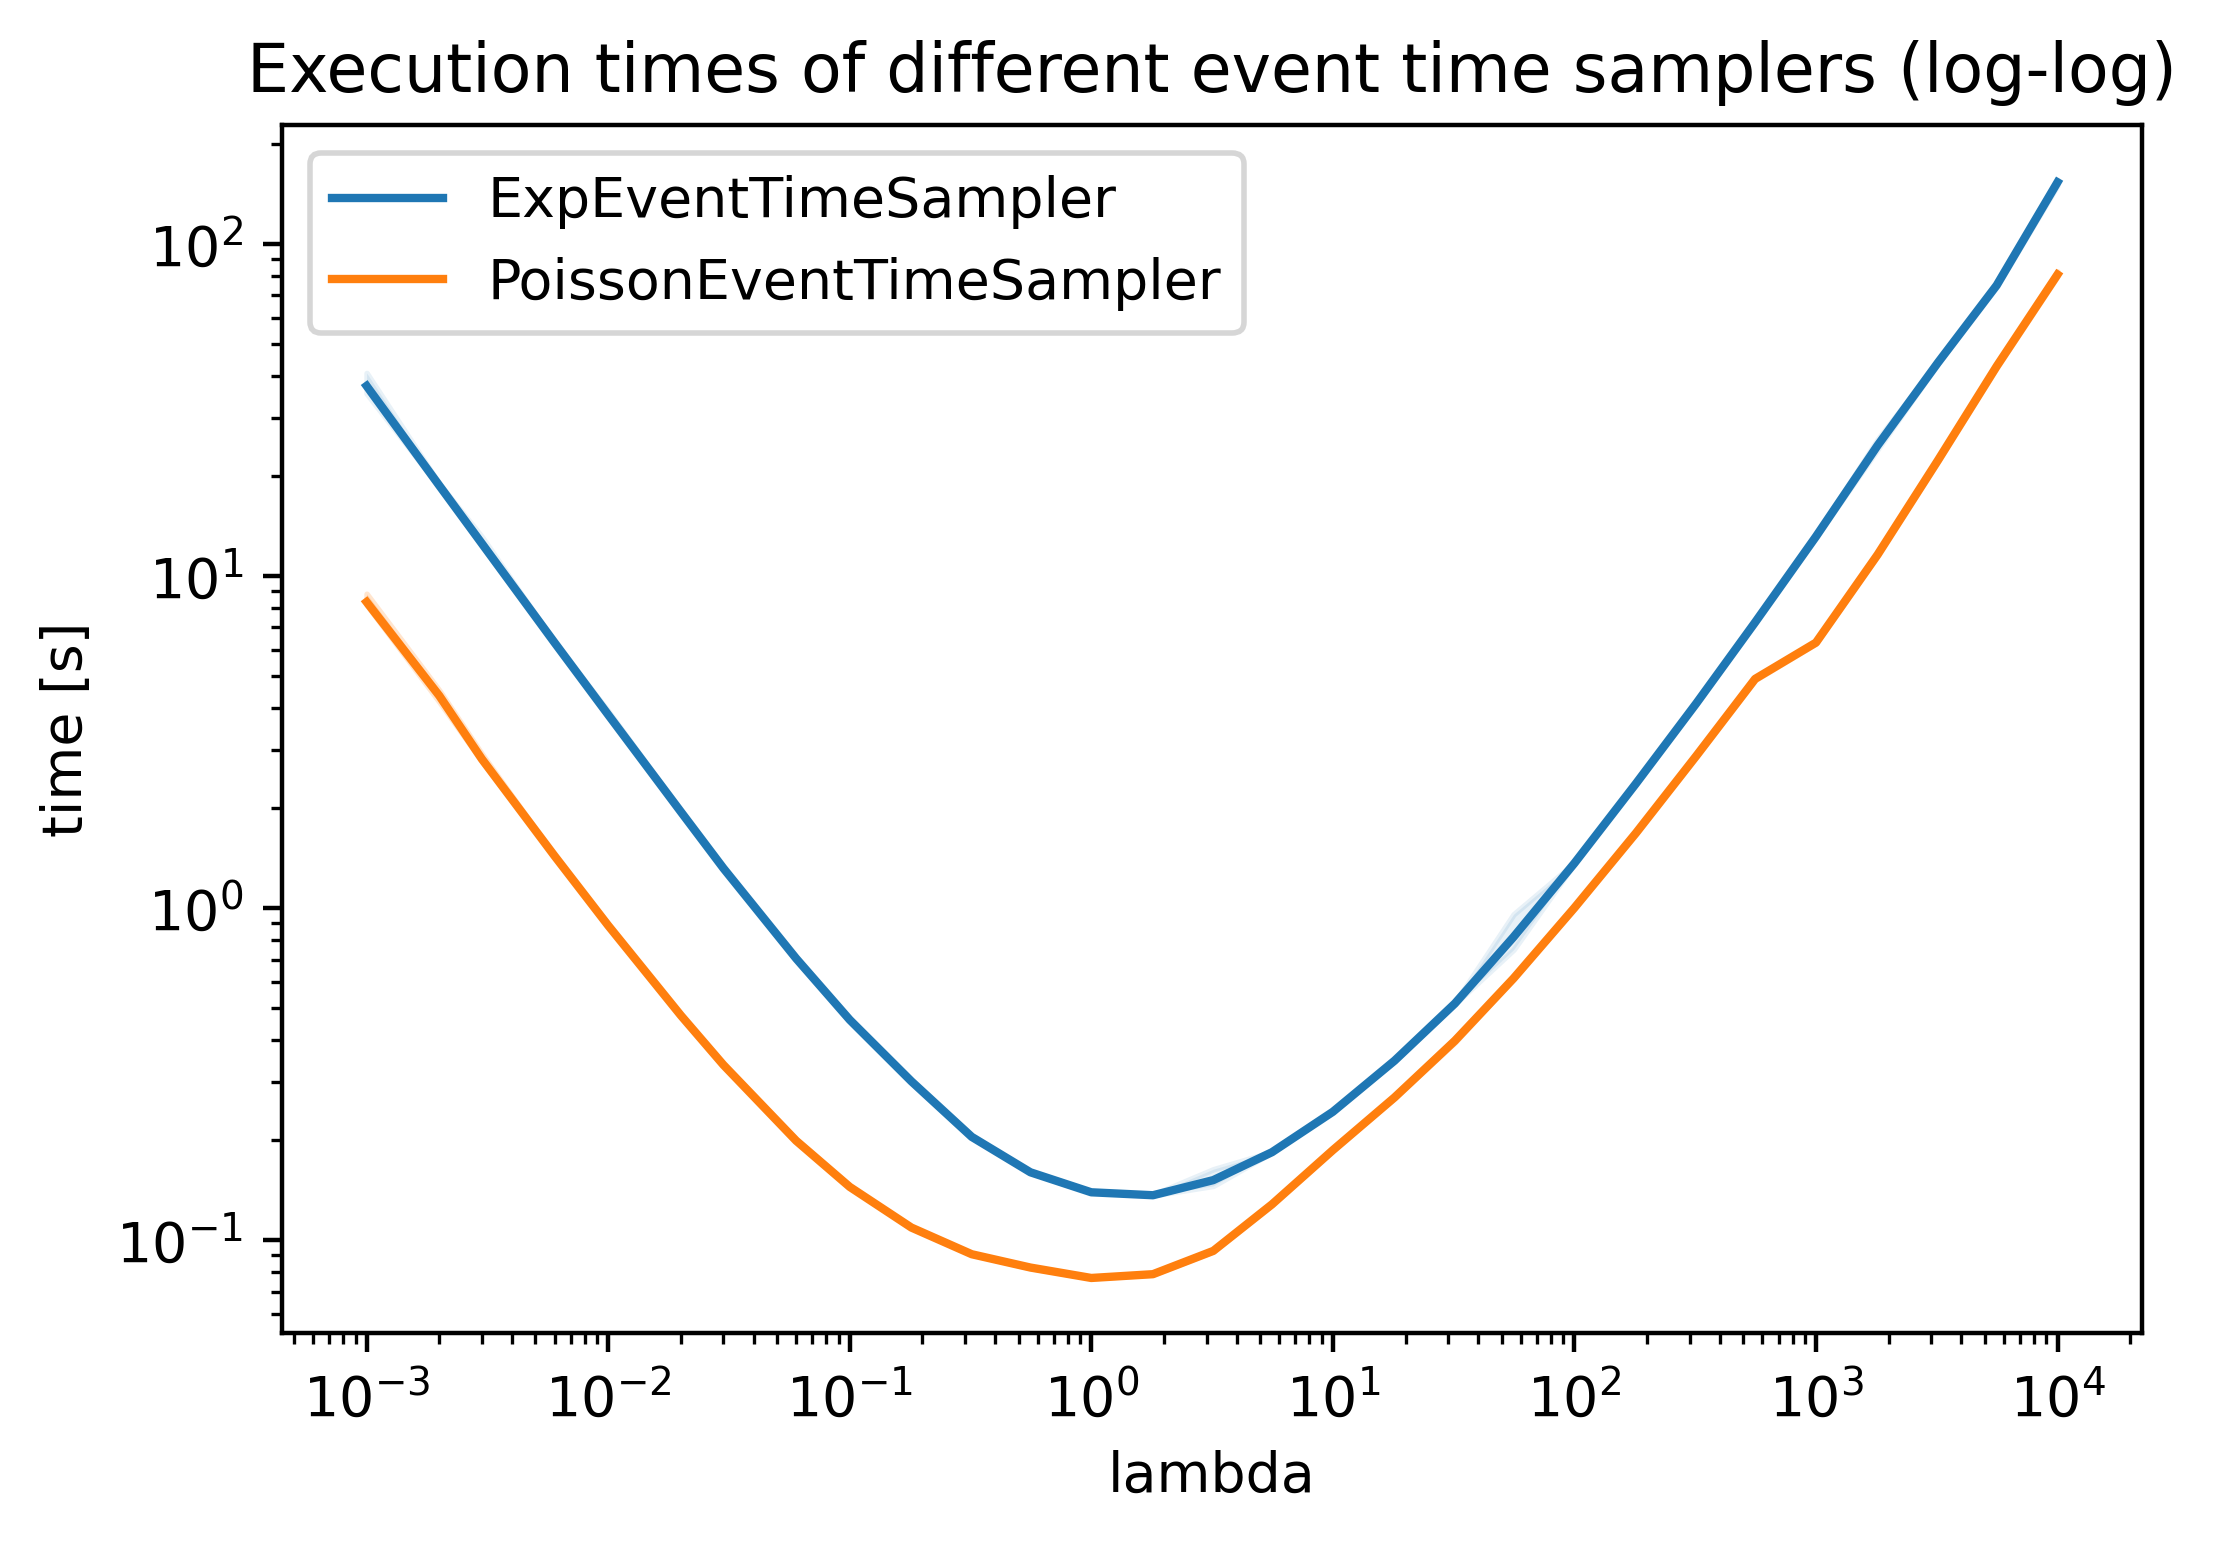

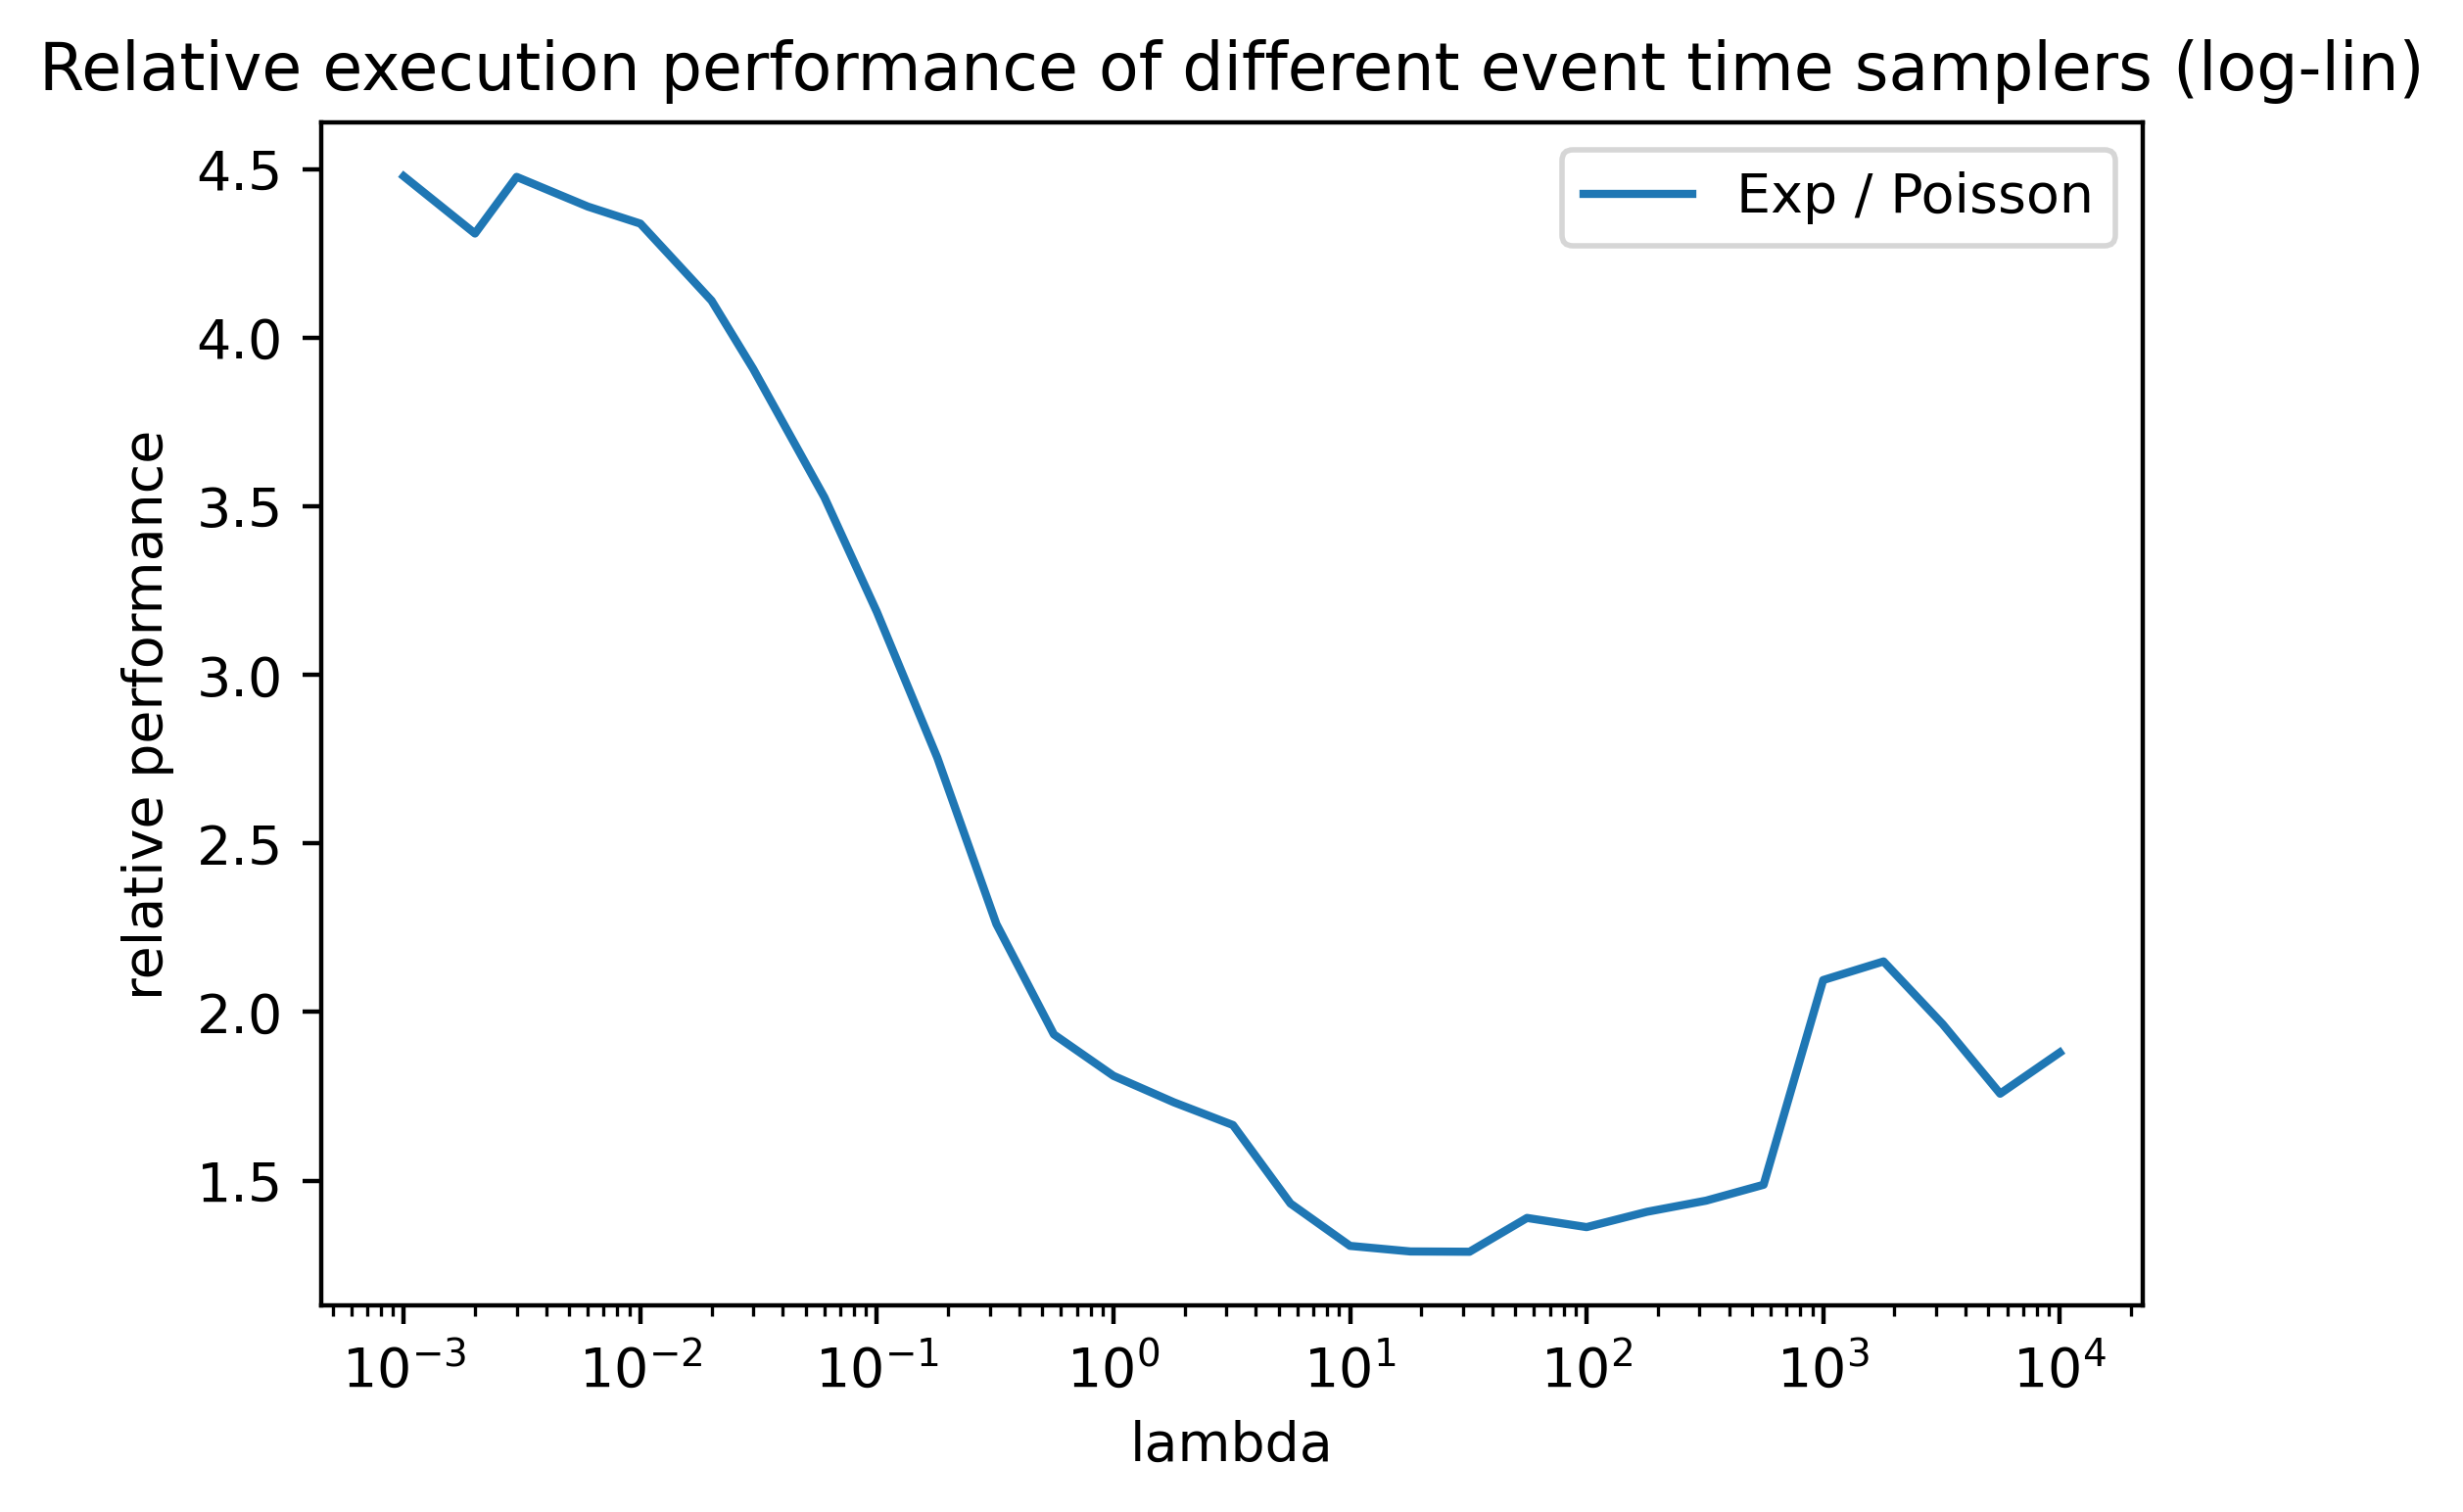

In [6]:
plt.title("Execution times of different event time samplers (log-log)")
plt.xlabel("lambda")
plt.ylabel("time [s]")
plt.xscale("log")
plt.yscale("log")

plt.plot(lambdas, np.median(exp_times, axis=1), label="ExpEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(exp_times, axis=1) - np.std(exp_times, axis=1),
    np.mean(exp_times, axis=1) + np.std(exp_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.1
)
plt.plot(lambdas, np.median(poi_times, axis=1), label="PoissonEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(poi_times, axis=1) - np.std(poi_times, axis=1),
    np.mean(poi_times, axis=1) + np.std(poi_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.2
)
plt.legend()
plt.show()

plt.title("Relative execution performance of different event time samplers (log-lin)")
plt.xlabel("lambda")
plt.ylabel("relative performance")
plt.xscale("log")
plt.plot(lambdas, [e / p for e, p in zip(np.mean(exp_times, axis=1), np.mean(poi_times, axis=1))], label="Exp / Poisson")
plt.legend()
plt.show()